# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

ImportError: dlopen(/Users/mravi/Desktop/C/CS231n/assignments/assignment2/.env/lib/python3.6/site-packages/scipy/special/_ufuncs.cpython-36m-darwin.so, 2): Library not loaded: /usr/local/opt/gcc/lib/gcc/6/libgfortran.3.dylib
  Referenced from: /Users/mravi/Desktop/C/CS231n/assignments/assignment2/.env/lib/python3.6/site-packages/scipy/special/_ufuncs.cpython-36m-darwin.so
  Reason: image not found

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

In [127]:
hog_feature(X_train[i]).astype('uint8')

array([0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0,
       0, 0, 1, 2, 2, 0, 2, 5, 5, 2, 1, 3, 1, 6, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 0, 0, 0, 1, 0, 1, 1, 1, 5, 2, 1,
       3, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0], dtype=uint8)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [29]:
from cs231n.features import *

num_color_bins = 90 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [269]:
color_histogram_hsv(im).shape

(10,)

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [32]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = np.logspace(-10,-8,7) 
#[1e-9,1e-8,4e-8,9e-8]
regularization_strengths = np.logspace(5,7,4) 
#[5e5,8e5,5e6,8e6,5e7]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
iters=1500
for i in learning_rates:
    for j in regularization_strengths:
        #Model Training
        model = LinearSVM()
        #print(i,j)
        model.train(X_train_feats,y_train,learning_rate=i,reg=j,num_iters=iters,verbose=True)
        #Prediction and Accuracy Calculation
        y_train_prediction = model.predict(X_train_feats)
        training_accuracy = np.mean(y_train==y_train_prediction)
        y_val_prediction = model.predict(X_val_feats)
        validation_accuracy = np.mean(y_val==y_val_prediction)
        
        results[(i,j)] = (training_accuracy, validation_accuracy)
        
        if best_val < validation_accuracy:
            best_svm = model
            best_val = validation_accuracy
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
#best validation accuracy achieved during cross-validation: 0.440000

iteration 0 / 1500: loss 252.803654
iteration 100 / 1500: loss 251.833744
iteration 200 / 1500: loss 250.870082
iteration 300 / 1500: loss 249.911153
iteration 400 / 1500: loss 248.940898
iteration 500 / 1500: loss 247.989486
iteration 600 / 1500: loss 247.041851
iteration 700 / 1500: loss 246.088265
iteration 800 / 1500: loss 245.131085
iteration 900 / 1500: loss 244.185650
iteration 1000 / 1500: loss 243.250119
iteration 1100 / 1500: loss 242.329998
iteration 1200 / 1500: loss 241.378123
iteration 1300 / 1500: loss 240.466247
iteration 1400 / 1500: loss 239.522756
iteration 0 / 1500: loss 1142.208444
iteration 100 / 1500: loss 1121.345937
iteration 200 / 1500: loss 1100.909205
iteration 300 / 1500: loss 1080.808690
iteration 400 / 1500: loss 1061.090378
iteration 500 / 1500: loss 1041.746242
iteration 600 / 1500: loss 1022.744405
iteration 700 / 1500: loss 1004.100934
iteration 800 / 1500: loss 985.787522
iteration 900 / 1500: loss 967.817997
iteration 1000 / 1500: loss 950.186474
it

In [33]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.419


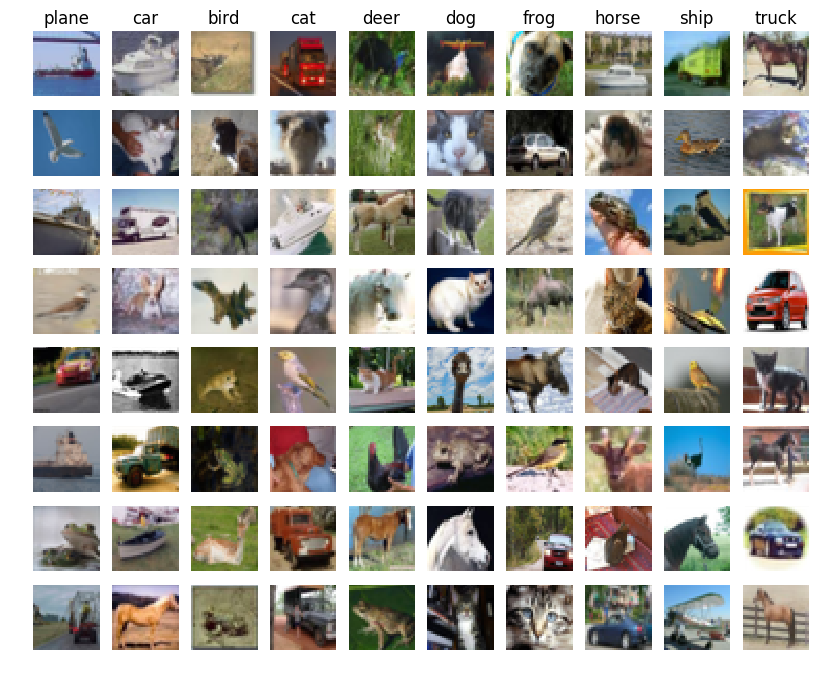

In [34]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Answer: The misclassifications make sense. From the definition above : "HOG should capture the texture of the image while ignoring color information, and the color histogram represents the color of the input image while ignoring texture". The misclassified results that we see are those of images which have either edges/texture or color information similar to that of the original class.Examples: 
-A bird in a blue background is misclassfied as plane. 
-A white cat and a white horse are misclassified as a dog.
-Since cars, trucks and ships have similar edges they are misclassified among each other.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [35]:
print(X_train_feats.shape)

(49000, 235)


In [46]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
from cs231n.classifiers.neural_net import TwoLayerNet
best_val = -1
input_size = 32 * 32 * 3
num_classes = 10
results = {}


#hidden_size = 135

learning_rates = [1e-0,1e-2,1e-4]
#learning_rates = np.logspace(-3,-1,10)

regularization_strengths = [1e-0,5e-2,5e-3]
#regularization_strengths = [2.5e4, 5e4]
#regularization_strengths = np.logspace(-3,2,10)

for i in learning_rates:
    for j in regularization_strengths:
        #Model Training
        model = TwoLayerNet(input_dim, hidden_dim, num_classes)
        #print(i,j)
        model.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1100, batch_size=400,
            learning_rate=i, learning_rate_decay=0.95,
            reg=j)
        #Prediction and Accuracy Calculation
        y_train_prediction = model.predict(X_train_feats)
        training_accuracy = np.mean(y_train==y_train_prediction)
        y_val_prediction = model.predict(X_val_feats)
        validation_accuracy = np.mean(y_val==y_val_prediction)
        #print(validation_accuracy)
        results[(i,j)] = (training_accuracy, validation_accuracy)
        
        if best_val < validation_accuracy:
            best_net = TwoLayerNet(input_dim, hidden_dim, num_classes)
            best_lr=i
            best_rs=j
            best_val = validation_accuracy
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
#best validation accuracy achieved during cross-validation: 0.564000
best_net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1500, batch_size=2000,
            learning_rate=best_lr, learning_rate_decay=0.995,
            reg=best_rs, verbose=True)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

best validation accuracy achieved during cross-validation: 0.564000
iteration 0 / 1500: loss 2.302591
iteration 100 / 1500: loss 1.406301
iteration 200 / 1500: loss 1.438823
iteration 300 / 1500: loss 1.429468
iteration 400 / 1500: loss 1.395297
iteration 500 / 1500: loss 1.410563
iteration 600 / 1500: loss 1.361055
iteration 700 / 1500: loss 1.373378
iteration 800 / 1500: loss 1.395338
iteration 900 / 1500: loss 1.361174
iteration 1000 / 1500: loss 1.379580
iteration 1100 / 1500: loss 1.337233
iteration 1200 / 1500: loss 1.356433
iteration 1300 / 1500: loss 1.354447
iteration 1400 / 1500: loss 1.370109


{'loss_history': [2.3025911575021851,
  2.3025068999639973,
  2.3023485658376104,
  2.3022321142577344,
  2.3031246779917365,
  2.3026408013390673,
  2.3027516884839696,
  2.3025368957253836,
  2.3021192466998781,
  2.3028173397101983,
  2.301958317156235,
  2.3007069612842783,
  2.2991212341253204,
  2.2950562332363842,
  2.2888262229155449,
  2.2731179885524821,
  2.2486464479628712,
  2.20042255393667,
  2.1578403658415088,
  2.1402534093387193,
  2.0851172435375003,
  2.0503227389527225,
  2.0243573015714338,
  1.9585071518836157,
  1.9082838746947548,
  1.8846185139826233,
  1.8412224181218382,
  1.8106411622699692,
  1.7839582518594546,
  1.7798152425598779,
  1.7704670144142338,
  1.7289398277261006,
  1.7284548547098839,
  1.7362738174399708,
  1.6853222368165219,
  1.6999266801112123,
  1.6783227005931691,
  1.6697673476394086,
  1.6924075959677665,
  1.6563190592900165,
  1.657545330794663,
  1.6485885020744575,
  1.6460629123072732,
  1.5927265982141652,
  1.5840600750879812

In [47]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.566


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

# 1) Experimenting on Threshold Imaging

We experiment on otsu threshold imaging to see how it reduces unwanted background information and thereby helps in reducing intraclass variance. Single Image Example displayed below:

In [1]:
from skimage.feature import greycomatrix, greycoprops
idx =400

ModuleNotFoundError: No module named 'skimage'

In [254]:
rgb = X_test[idx]
#Converting to gray scale
gray_val = np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [ ]:
rgb = X_test[idx]
#Converting to gray scale
gray_val = np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
#Original Image
from matplotlib.pyplot import *
fig, ax = subplots(figsize=(20,1))
plt.imshow(X_test[idx].astype('uint8'))
#applying gaussian filter helps reduce unwanted noise
from scipy.ndimage import gaussian_filter
blurred_image = gaussian_filter(gray_val,sigma=1)
fig, ax = subplots(figsize=(20,1))
plt.imshow(blurred_image.astype('uint8'))
#otsu threshold imaging
from skimage.filter import threshold_otsu
thresh = threshold_otsu(blurred_image)
binary = gray_val > thresh

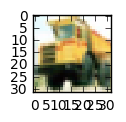

In [256]:
#Original Image
from matplotlib.pyplot import *
fig, ax = subplots(figsize=(20,1))
plt.imshow(X_test[idx].astype('uint8'))
#Grayscale Image
fig, ax = subplots(figsize=(20,1))
plt.imshow(gray_val.astype('uint8'))

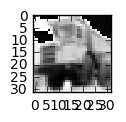

In [257]:
#Grayscale Image
fig, ax = subplots(figsize=(20,1))
plt.imshow(gray_val.astype('uint8'))

In [258]:
#applying gaussian filter helps reduce unwanted noise
from scipy.ndimage import gaussian_filter
blurred_image = gaussian_filter(gray_val,sigma=1)

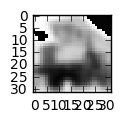

In [267]:
fig, ax = subplots(figsize=(20,1))
plt.imshow(blurred_image.astype('uint8'))

In [261]:
#otsu threshold imaging
from skimage.filter import threshold_otsu
thresh = threshold_otsu(blurred_image)
binary = gray_val > thresh

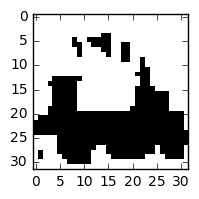

In [262]:
fig, ax = subplots(figsize=(18,2))
plt.imshow(binary)

In [271]:
#Otsu Threshold Imaging Function
from skimage.filter import threshold_otsu
from scipy.ndimage import gaussian_filter
def otsu_threshold(im):
    rgb = im
    #Converting to gray scale
    gray_val = np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
    blurred_image = gaussian_filter(gray_val,sigma=1)
    thresh = threshold_otsu(blurred_image)
    binary = gray_val > thresh
    binary = binary.flatten()
    return binary

# 2) Experimenting on PCA

We pick up all the training images and perform PCA using scikit functions and find that about 250 components out of about 3072 dimensions explain 95% of the variance. Similarly we pick up a single image and create a customized PCA which converts a single image to black and white and calculates PCA along one axis of a 2-D image. We get 95% of variance explained by about 7 components (out of 32 dimensions along one axis). Extending these observations

In [163]:
from numpy import *
im=X_test[idx].astype('uint8')
#im=mean(im,2)
im=im.reshape(1, -1)
#im=im.T


In [178]:
import numpy as np
from sklearn.decomposition import PCA
a=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
pca = PCA(n_components = 'mle')
#0.99999996593204932 for 3068
pca.fit(a)

PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [182]:
print(pca.explained_variance_ratio_)

[  2.90678870e-01   1.12640231e-01   6.68687726e-02 ...,   9.44060703e-09
   9.24442242e-09   8.87091305e-09]


In [ ]:
pca = PCA(n_components = 250)
#0.99999996593204932 for 3068
pca.fit(a)

In [277]:
#PCA calculation Function
from numpy import *
from pylab import *
def PCA(im,n_comp=10):
    im=mean(im,2)
    eig_mat=(im-mean(im.T,axis=1)).T
    val,vec=linalg.eig(cov(eig_mat))
    vec_size=size(vec,axis=1)
    #Sorting eigen values  
    idx=argsort(val) 
    idx=idx[::-1]
    val = val[idx] 
    #Sorting eigen vectors
    vec=vec[:,idx]
    if n_comp < vec_size and n_comp >= 0:
      #truncating
      vec=vec[:,range(n_comp)] 
    scores=dot(vec.T,eig_mat)
    reconstructed_im_temp = np.dot(vec,scores).T+mean(im,axis=0)
    reconstructed_im=flipud(reconstructed_im_temp)
    #return val,vec,scores,reconstructed_im
    reconstructed_im=reconstructed_im.flatten()
    return reconstructed_im

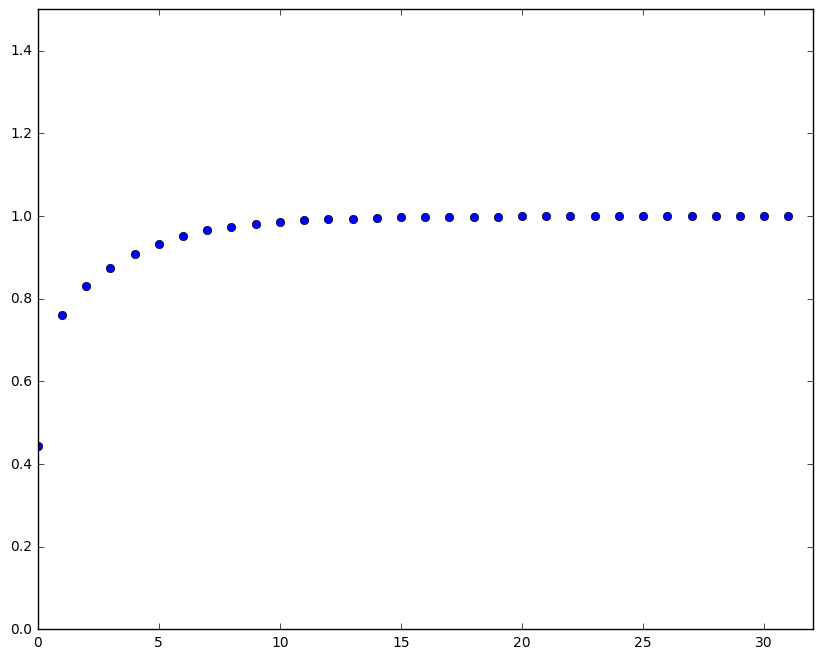

In [242]:
figure()
legend(loc='upper center', shadow=True)
#val return commented out for feature extraction process
perc = cumsum(val)/sum(val)
plot(range(len(perc)),perc,'o',label='sum of variances')
axis([0,dim,0,1.5])
show()

In [273]:
im=X_test[idx].astype('uint8')
reconstructed_im = PCA(im,n_comp=10)
otsu_im = otsu_threshold(im)

# 3) Hyperparameter tuning using otsu and PCA on SVM

Feature Extraction

In [280]:
from cs231n.features import *

feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins),PCA,otsu_threshold]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [283]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = np.logspace(-10,0,10) 
#[1e-9,1e-8,4e-8,9e-8]
#regularization_strengths = np.logspace(5,7,4) 
#[5e5,8e5,5e6,8e6,5e7]
regularization_strengths=[0.01, 0.001]
results = {}
best_val = -1
best_svm = None

iters=1500
for i in learning_rates:
    for j in regularization_strengths:
        #Model Training
        model = LinearSVM()
        #print(i,j)
        model.train(X_train_feats,y_train,learning_rate=i,reg=j,num_iters=iters,verbose=True)
        #Prediction and Accuracy Calculation
        y_train_prediction = model.predict(X_train_feats)
        training_accuracy = np.mean(y_train==y_train_prediction)
        y_val_prediction = model.predict(X_val_feats)
        validation_accuracy = np.mean(y_val==y_val_prediction)
        
        results[(i,j)] = (training_accuracy, validation_accuracy)
        
        if best_val < validation_accuracy:
            best_svm = model
            best_val = validation_accuracy
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
 

iteration 0 / 1500: loss 8.974851
iteration 100 / 1500: loss 9.059810
iteration 200 / 1500: loss 9.058627
iteration 300 / 1500: loss 8.996719
iteration 400 / 1500: loss 9.099870
iteration 500 / 1500: loss 9.047597
iteration 600 / 1500: loss 9.010525
iteration 700 / 1500: loss 9.008502
iteration 800 / 1500: loss 9.097144
iteration 900 / 1500: loss 9.037070
iteration 1000 / 1500: loss 9.093509
iteration 1100 / 1500: loss 9.063873
iteration 1200 / 1500: loss 9.125592
iteration 1300 / 1500: loss 9.108131
iteration 1400 / 1500: loss 8.958765
iteration 0 / 1500: loss 9.059448
iteration 100 / 1500: loss 9.042441
iteration 200 / 1500: loss 9.027702
iteration 300 / 1500: loss 9.026086
iteration 400 / 1500: loss 8.983280
iteration 500 / 1500: loss 8.988683
iteration 600 / 1500: loss 9.009825
iteration 700 / 1500: loss 8.990968
iteration 800 / 1500: loss 9.029440
iteration 900 / 1500: loss 9.003559
iteration 1000 / 1500: loss 8.978550
iteration 1100 / 1500: loss 8.995673
iteration 1200 / 1500: lo

In [ ]:
#best validation accuracy achieved during cross-validation: 0.535000